<a href="https://colab.research.google.com/github/SharmilNK/XAI/blob/main/ExplanableDeepLearning_SN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #5
### Explainable Deep Learning
### Sharmil NK

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/templates/template.ipynb)

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI" # Change to your repo name
git_path = 'https://github.com/SharmilNK/XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

'rm' is not recognized as an internal or external command,
operable program or batch file.


c:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\Duke-AI-XAI\templates\Duke-AI-XAI\templates


Cloning into 'Duke-AI-XAI'...


 Volume in drive C is Local Disk
 Volume Serial Number is 6C9D-63BA

 Directory of c:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\Duke-AI-XAI\templates\Duke-AI-XAI\templates

10/03/2025  03:49 PM    <DIR>          .
10/03/2025  03:49 PM    <DIR>          ..
10/03/2025  03:49 PM             3,939 template.ipynb
               1 File(s)          3,939 bytes
               2 Dir(s)  57,962,147,840 bytes free


In [ ]:
import kagglehub

# Download dataset from Kaggle
path = kagglehub.dataset_download("arwabasal/brain-tumor-mri-detection")

print("Path to dataset files:", path)


c:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\gradcam_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\som\.cache\kagglehub\datasets\arwabasal\brain-tumor-mri-detection\versions\1


In [ ]:
import os
from PIL import Image

dataset_path = path

# Loop through subfolders and files & read images
for subfolder in os.listdir(dataset_path):
    sub_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(sub_path):   # makes sure it's a folder
        print("Subfolder:", subfolder)

        for filename in os.listdir(sub_path):
            file_path = os.path.join(sub_path, filename)

            if os.path.isfile(file_path):   # makes sure it's a file
                try:
                    img = Image.open(file_path)
                    print(f"{filename} → size: {img.size}, mode: {img.mode}")
                except Exception as e:
                    print("Error with:", file_path, "|", e)


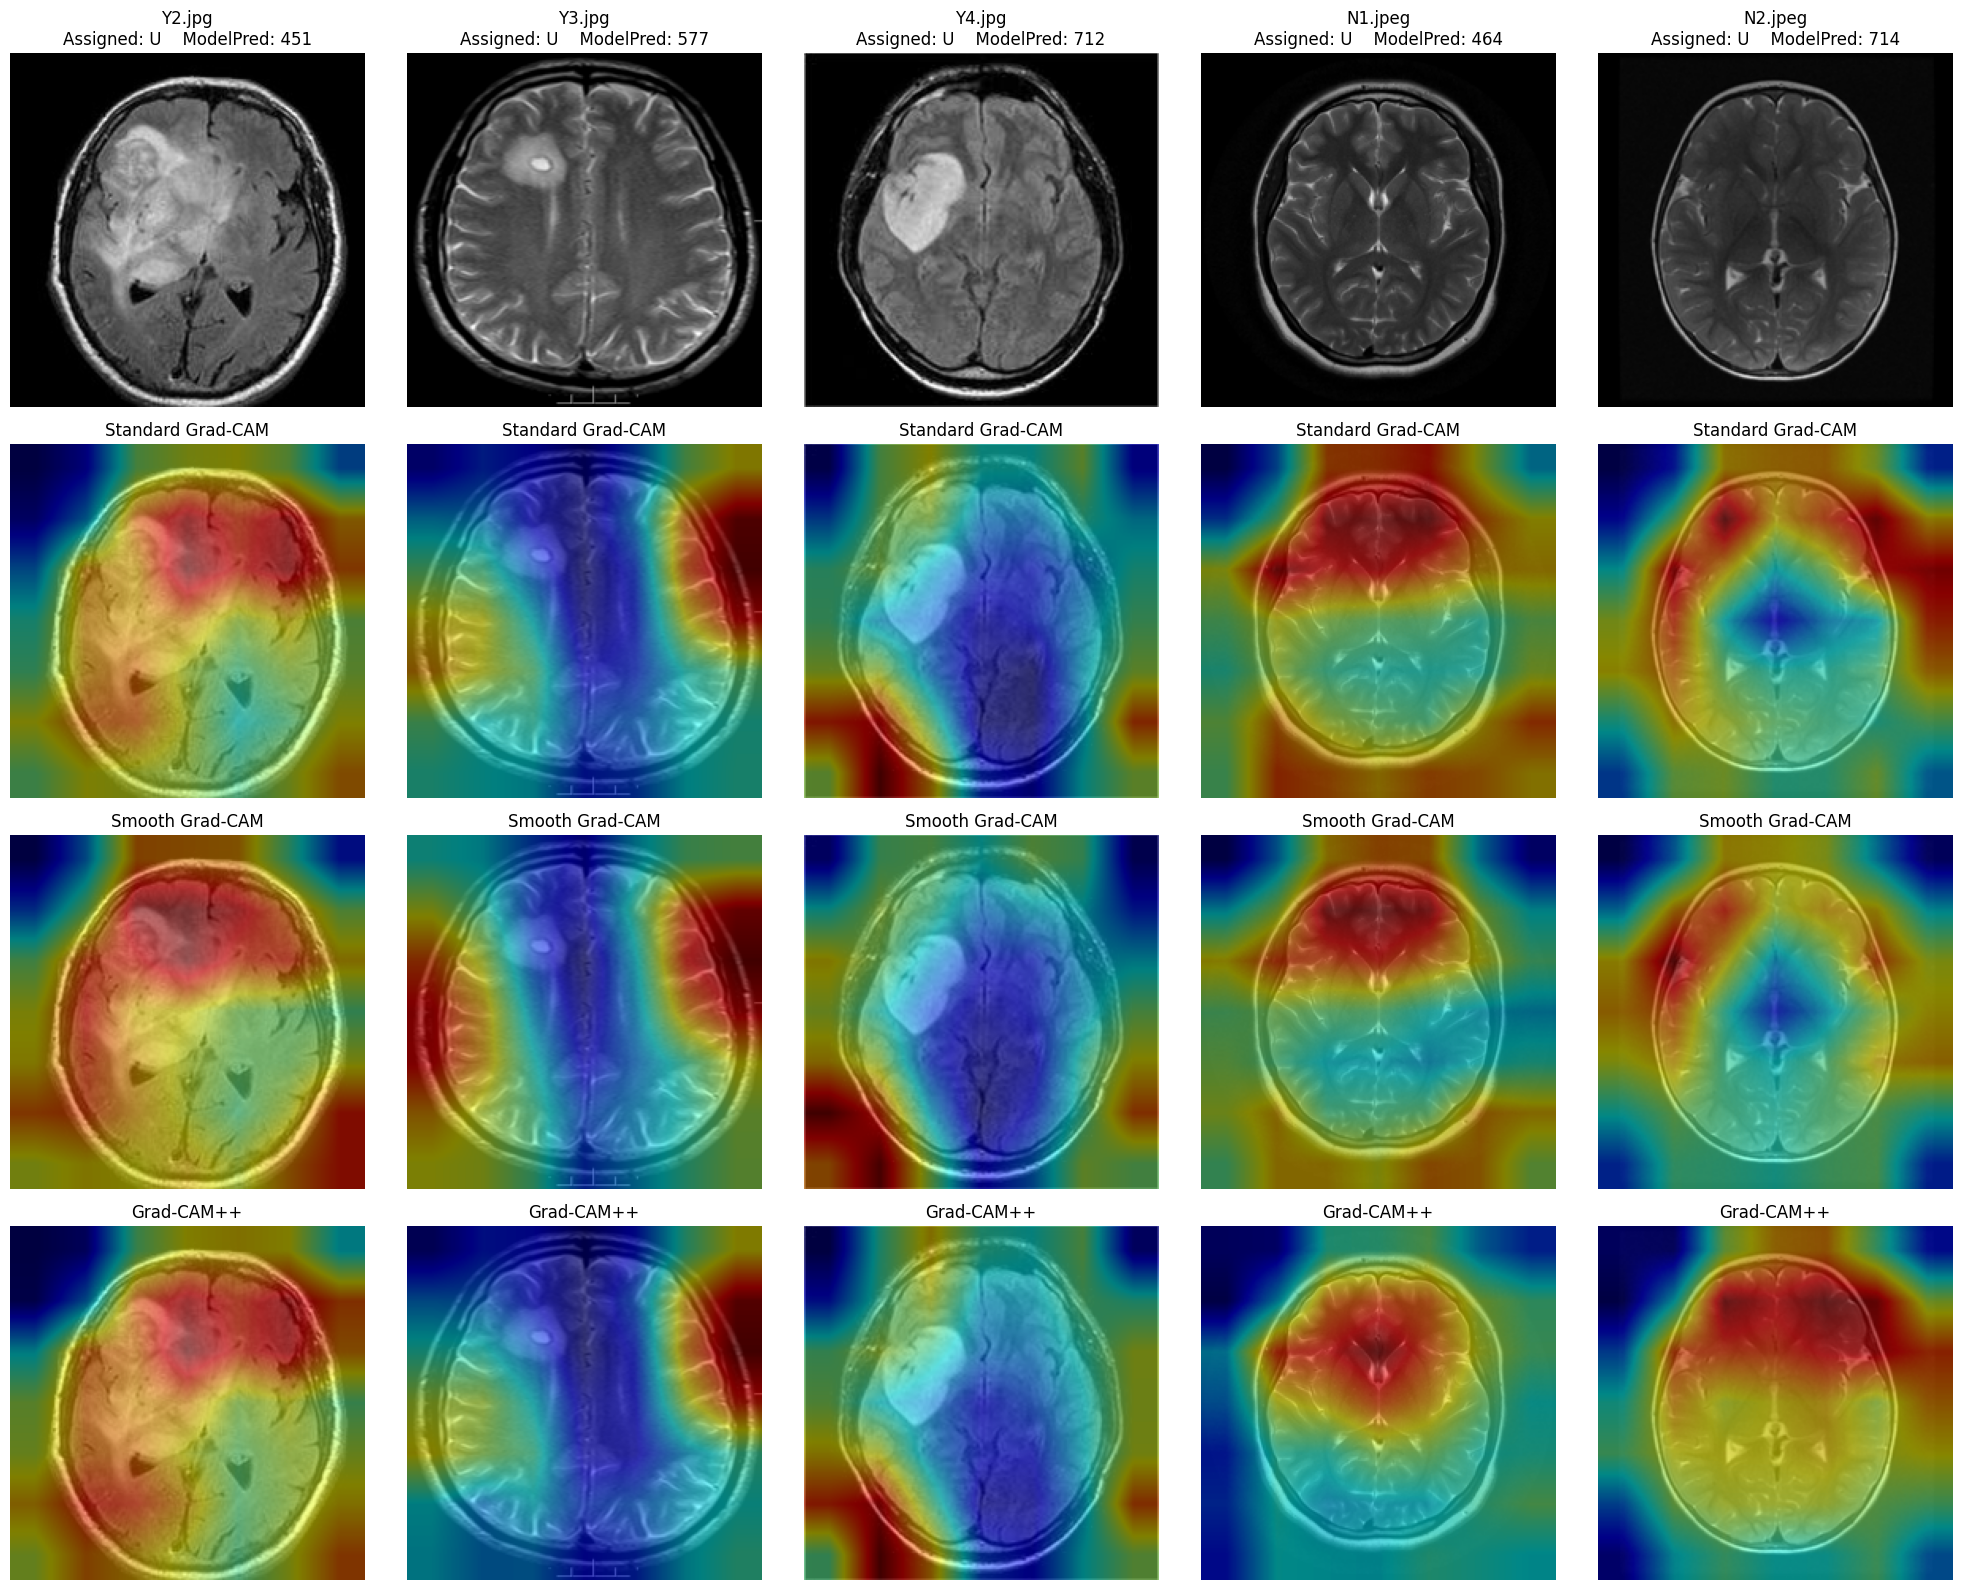

Saved overlays (with Assigned labels) to: c:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\gradcam_outputs


In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ---------------- CONFIG ----------------

# Path of five images (container/local paths)
image_paths = [r"C:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\Y2.jpg", r"C:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\Y3.jpg",
r"C:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\Y4.jpg", r"C:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\N1.jpeg",  r"C:\Users\som\Desktop\CourseSem1\XAI\DeepLearn\N2.jpeg"]

# Map basename -> assigned label "Y" or "N"
assigned_labels = {
    "Y2.png": "Y",
    "Y3.png": "Y",
    "Y4.png": "Y",
    "N1.png": "N",
    "N2.png": "N",
}

output_dir = "./gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- MODEL (older API) ----------------
model = resnet50(pretrained=True).to(device)
model.eval()

# Manual ImageNet preprocessing (older torchvision API)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Target layer (last conv block)
target_layers = [model.layer4[-1]]

# Create CAM objects once
cam_standard_obj = GradCAM(model=model, target_layers=target_layers)
cam_smooth_obj = GradCAM(model=model, target_layers=target_layers)   # will call with aug_smooth=True
cam_pp_obj = GradCAMPlusPlus(model=model, target_layers=target_layers)

# ---------------- HELPERS ----------------
def load_image(path, size=(224, 224)):
    img = Image.open(path).convert("RGB")
    original_np = np.array(img.resize(size)).astype(np.float32) / 255.0  # for overlay visualization
    input_tensor = preprocess(img).unsqueeze(0).to(device)  # (1,C,H,W)
    return input_tensor, original_np

def _normalize_map(cam_map):
    gmin, gmax = float(cam_map.min()), float(cam_map.max())
    if gmax - gmin > 1e-8:
        return (cam_map - gmin) / (gmax - gmin)
    return cam_map

def safe_filename(name: str) -> str:
    """Remove characters that are illegal in Windows filenames and collapse spaces."""
    illegal = r'<>:"/\\|?*'
    cleaned = "".join(c for c in name if c not in illegal)
    # replace any remaining whitespace with underscore
    cleaned = "_".join(cleaned.split())
    return cleaned

def get_standard_gradcam(cam_obj, input_tensor, original_image_np, target_index):
    targets = [ClassifierOutputTarget(int(target_index))]
    grayscale_cam = cam_obj(input_tensor=input_tensor, targets=targets)[0, :]
    grayscale_cam = _normalize_map(grayscale_cam)
    overlay = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)
    return grayscale_cam, overlay

def get_smooth_gradcam(cam_obj, input_tensor, original_image_np, target_index):
    targets = [ClassifierOutputTarget(int(target_index))]
    grayscale_cam = cam_obj(input_tensor=input_tensor, targets=targets, aug_smooth=True)[0, :]
    grayscale_cam = _normalize_map(grayscale_cam)
    overlay = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)
    return grayscale_cam, overlay

def get_gradcam_plus_plus(cam_pp_obj, input_tensor, original_image_np, target_index):
    targets = [ClassifierOutputTarget(int(target_index))]
    grayscale_cam = cam_pp_obj(input_tensor=input_tensor, targets=targets)[0, :]
    grayscale_cam = _normalize_map(grayscale_cam)
    overlay = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)
    return grayscale_cam, overlay

# ---------------- PROCESS IMAGES ----------------
results = []  # list of dicts per image

for path in image_paths:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")
    base = os.path.basename(path)
    assigned = assigned_labels.get(base, "U")  # "Y" or "N" or "U" (unknown)
    input_tensor, original_np = load_image(path)

    # Model prediction (ImageNet class index)
    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = int(outputs.argmax(dim=1).item())

    # Generate CAMs (standard, smooth, grad-cam++)
    g_std, ov_std = get_standard_gradcam(cam_standard_obj, input_tensor, original_np, pred_idx)
    g_smooth, ov_smooth = get_smooth_gradcam(cam_smooth_obj, input_tensor, original_np, pred_idx)
    g_pp, ov_pp = get_gradcam_plus_plus(cam_pp_obj, input_tensor, original_np, pred_idx)

    # Save overlays with assigned label in filename (use safe_filename)
    def _save(arr, filename):
        try:
            arr_uint8 = (arr * 255).astype(np.uint8) if arr.max() <= 1.0 else arr.astype(np.uint8)
            fname = safe_filename(filename)
            out_path = os.path.join(output_dir, fname)
            Image.fromarray(arr_uint8).save(out_path)
        except Exception as e:
            print(f"Warning: failed to save {filename}: {e}")

    safe_base = os.path.splitext(base)[0]
    _save(ov_std, f"{safe_base}_Pred-{assigned}_ModelIdx-{pred_idx}_standard.png")
    _save(ov_smooth, f"{safe_base}_Pred-{assigned}_ModelIdx-{pred_idx}_smooth.png")
    _save(ov_pp, f"{safe_base}_Pred-{assigned}_ModelIdx-{pred_idx}_gradcampp.png")
    # Also save original (resized) with label
    orig_uint8 = (original_np * 255).astype(np.uint8)
    _save(orig_uint8, f"{safe_base}_Pred-{assigned}_ModelIdx-{pred_idx}_orig.png")

    results.append({
        "path": path,
        "basename": base,
        "assigned_label": assigned,
        "model_pred_idx": pred_idx,
        "original_np": original_np,
        "overlay_standard": ov_std,
        "overlay_smooth": ov_smooth,
        "overlay_pp": ov_pp
    })

# ---------------- DISPLAY: 4 rows x N cols ----------------
n = len(results)
fig, axs = plt.subplots(4, n, figsize=(4 * n, 16))

for i, r in enumerate(results):
    base = r["basename"]
    assigned = r["assigned_label"]
    pred_idx = r["model_pred_idx"]

    # Row 0: original
    axs[0, i].imshow(r["original_np"])
    axs[0, i].set_title(f"{base}\nAssigned: {assigned}    ModelPred: {pred_idx}")
    axs[0, i].axis("off")

    # Row 1: standard
    ov_std = r["overlay_standard"]
    ov_std_disp = (ov_std * 255).astype(np.uint8) if ov_std.max() <= 1.0 else ov_std.astype(np.uint8)
    axs[1, i].imshow(ov_std_disp)
    axs[1, i].set_title("Standard Grad-CAM")
    axs[1, i].axis("off")

    # Row 2: smooth
    ov_smooth = r["overlay_smooth"]
    ov_smooth_disp = (ov_smooth * 255).astype(np.uint8) if ov_smooth.max() <= 1.0 else ov_smooth.astype(np.uint8)
    axs[2, i].imshow(ov_smooth_disp)
    axs[2, i].set_title("Smooth Grad-CAM")
    axs[2, i].axis("off")

    # Row 3: grad-cam++
    ov_pp = r["overlay_pp"]
    ov_pp_disp = (ov_pp * 255).astype(np.uint8) if ov_pp.max() <= 1.0 else ov_pp.astype(np.uint8)
    axs[3, i].imshow(ov_pp_disp)
    axs[3, i].set_title("Grad-CAM++")
    axs[3, i].axis("off")

plt.tight_layout()
plt.show()

print(f"Saved overlays (with Assigned labels) to: {os.path.abspath(output_dir)}")


Interpretation:

Standard Grad-CAM
This is the baseline version of GRAD CAM. The red and yellow zones depict where where the model looks at to predict the classification. Comparing to the original MRI scan, the red/yellow spots highlight the abnormal areas in th images i.e. the areas that led the model to predict the classification. However, we see that the heatmap spills outside the brain and for every run the zones change location. This is inaccurate and inconsistant. It shows that the model is not accurate, but it can be used to get a quick idea of what the model is paying attention to.

Smooth Grad-CAM
The Smooth Grad-CAM takes slightly changed versions of the same image and averages the CAMs. The result is a cleaner, less noisy heatmap. The red zones are more consistent and stable, but they also spread wider. This makes the zones look bigger and blurrier. We also see that we see that the heatmap spills outside the brain. Although this is much steadier, it still is not as sharp.

Grad-CAM++
This version modifies the gradient weighting to highlight smaller and multiple important areas more clearly. It has moe localized red zones. In these images it produces tight, focused red spots right on the lesions or contrast edges. It amplifys those pixels whose change would most strongly affect the models classification prediction.That makes it the sharpest of the three GRAD CAMs.

All three CAM maps explain the same model prediction for each image, they differ in spatial sharpness and robustness.

Note: This may not be the most accurate model. We see that the tumor in MRI image1 is highlighted in red/yellow zone - which depicts the tumor. However, the model misses the tumor in images 2,3.
Image 4,5 do not have tumor, yet the model highlights the upper portion of the brain in red/yellow.

Citation: The above interpretation in not AI generated. The code was generated using AI/ predefined models on Oct 4, 2025 11:27am